# Finding Similar Items

## 1.	Introduction


### Mining information from Text Data 

-	This project will explore and analyze the information stored in a particular dataset. In this case the ACL Anthology dataset (https://aclanthology.org/). We will explore different techniques for obtaining valuable information.

Randomly select 1000 abstracts from the whole dataset. Find the similar items using pairwise Jaccard similarities, MinHash and LSH (vectorized versions) .

   1. Compare the performance in time and the results for *k*-shingles = 3, 5 and 10, for the three methods and similarity thresholds *s*=0.1 and 0.2. Use 50 hashing functions. Comment your results. 
      
   2. Compare the results obtained for MinHash and LSH for different similarity thresholds *s* = 0.1, 0.2, 0.25 and 50, 100 and 200 hashing functions. Comment your results.
   
   3. For MinHashing using 100 hashing functions and *s* = 0.1 and 0.2,  find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each *s*. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?
 

-	Define all and only used package imports below

In [14]:
import requests # to download the dataset
import gzip
import shutil # to extract the gz file
import re # for text cleaning

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 

from nltk.corpus import stopwords # calculation of stopwords
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import itertools
from time import time
import binascii

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alext\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.	ELT

### Extract, Load and Transform of data.



- In your code data should be retrieved from an online source, NOT from your local drive, otherwise, nobody can run your code without additional effort.

In [2]:
# Download data 
url = 'https://aclanthology.org/anthology+abstracts.bib.gz'
fname = "anthology+abstracts.bib"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

# Extract the gz file
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
# Find all the rows in the file that contain an abstract and laod the text to a list
abstracts = []
with open(fname, "r",encoding="UTF-8") as f:
    s = f.readlines()
    for x in s:
        if x.__contains__('abstract'):
            start = x.find('   abstract = "') + len('   abstract = "')
            end = x.find('",')
            substring = x[start:end]
            abstracts.append(substring)
    f.close()

print("{} abstracts were found in the file.".format(len(abstracts)))

30747 abstracts were found in the file.


In [4]:
# Some cleaning

minletters = 200 
abstracts_clean = []

for a in abstracts: 
    if len(a) > minletters and len(re.findall('[a-zA-Z]',a)) >0.5*len(a):
        abstracts_clean.append(a) 
print("After cleaning, {} abstracts were remaining.".format(len(abstracts_clean)))

After cleaning, 30244 abstracts were remaining.


### Report the essential description of data.
-	Don’t print out dozens of raw lines.

In [5]:
data = pd.DataFrame(abstracts_clean, columns=['abstracts'])
# Number of words
data['word_count'] = data['abstracts'].apply(lambda x: len(str(x).split(" ")))
data[['abstracts','word_count']]

#Number of characters
data['char_count'] = data['abstracts'].str.len() ## this also includes spaces
data[['abstracts','char_count']]

# Average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['abstracts'].apply(lambda x: avg_word(x))

# Number of stop words 
stop = stopwords.words('english')
data['stopwords'] = data['abstracts'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of Uppercase words
data['upper'] = data['abstracts'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

# Descriptive statistics of the DataFrame
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
word_count,30244.0,132.231980,43.192249,22.000000,102.000,130.000000,159.000000,1077.000000
char_count,30244.0,912.664991,293.726094,201.000000,709.000,903.000000,1098.000000,7265.000000
avg_word,30244.0,5.934484,0.462690,4.151786,5.625,5.891566,6.184783,13.545455
stopwords,30244.0,43.460521,19.132772,0.000000,32.000,43.000000,55.000000,384.000000
upper,30244.0,2.351673,2.795535,0.000000,0.000,1.000000,3.000000,34.000000


In [6]:
text = " ".join(abstracts for abstracts in data.abstracts.astype(str))
print ("There are {} words in the combination of all cells in column abstracts.".format(len(text)))
stopwords = set(STOPWORDS)

# to exclude certain words
stopwords.update(["a", "about", "above", "after", "again", "against", "all", 'also' "am", "an", "and", "any", "are",
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", 
             "by", 'can', "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", 
             "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", 
             "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", 
             "most", "my", "myself", 'no', 'not', "nor", "of", "on", "once", "only", "or", "other", "ought", "our", 
             "ours", "ourselves", "out", "over", "own", 's', "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", 
             "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", 
             "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", 
             "we'll", "we're", "we've", "were", 'will', "what", "what's", "when", "when's", "where", "where's", 
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", 
             "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "br", "one", "want", "come", 
             "gets","without", 'rather', "although", "will", "see", "even","make", "seem"])


There are 27632883 words in the combination of all cells in column abstracts.


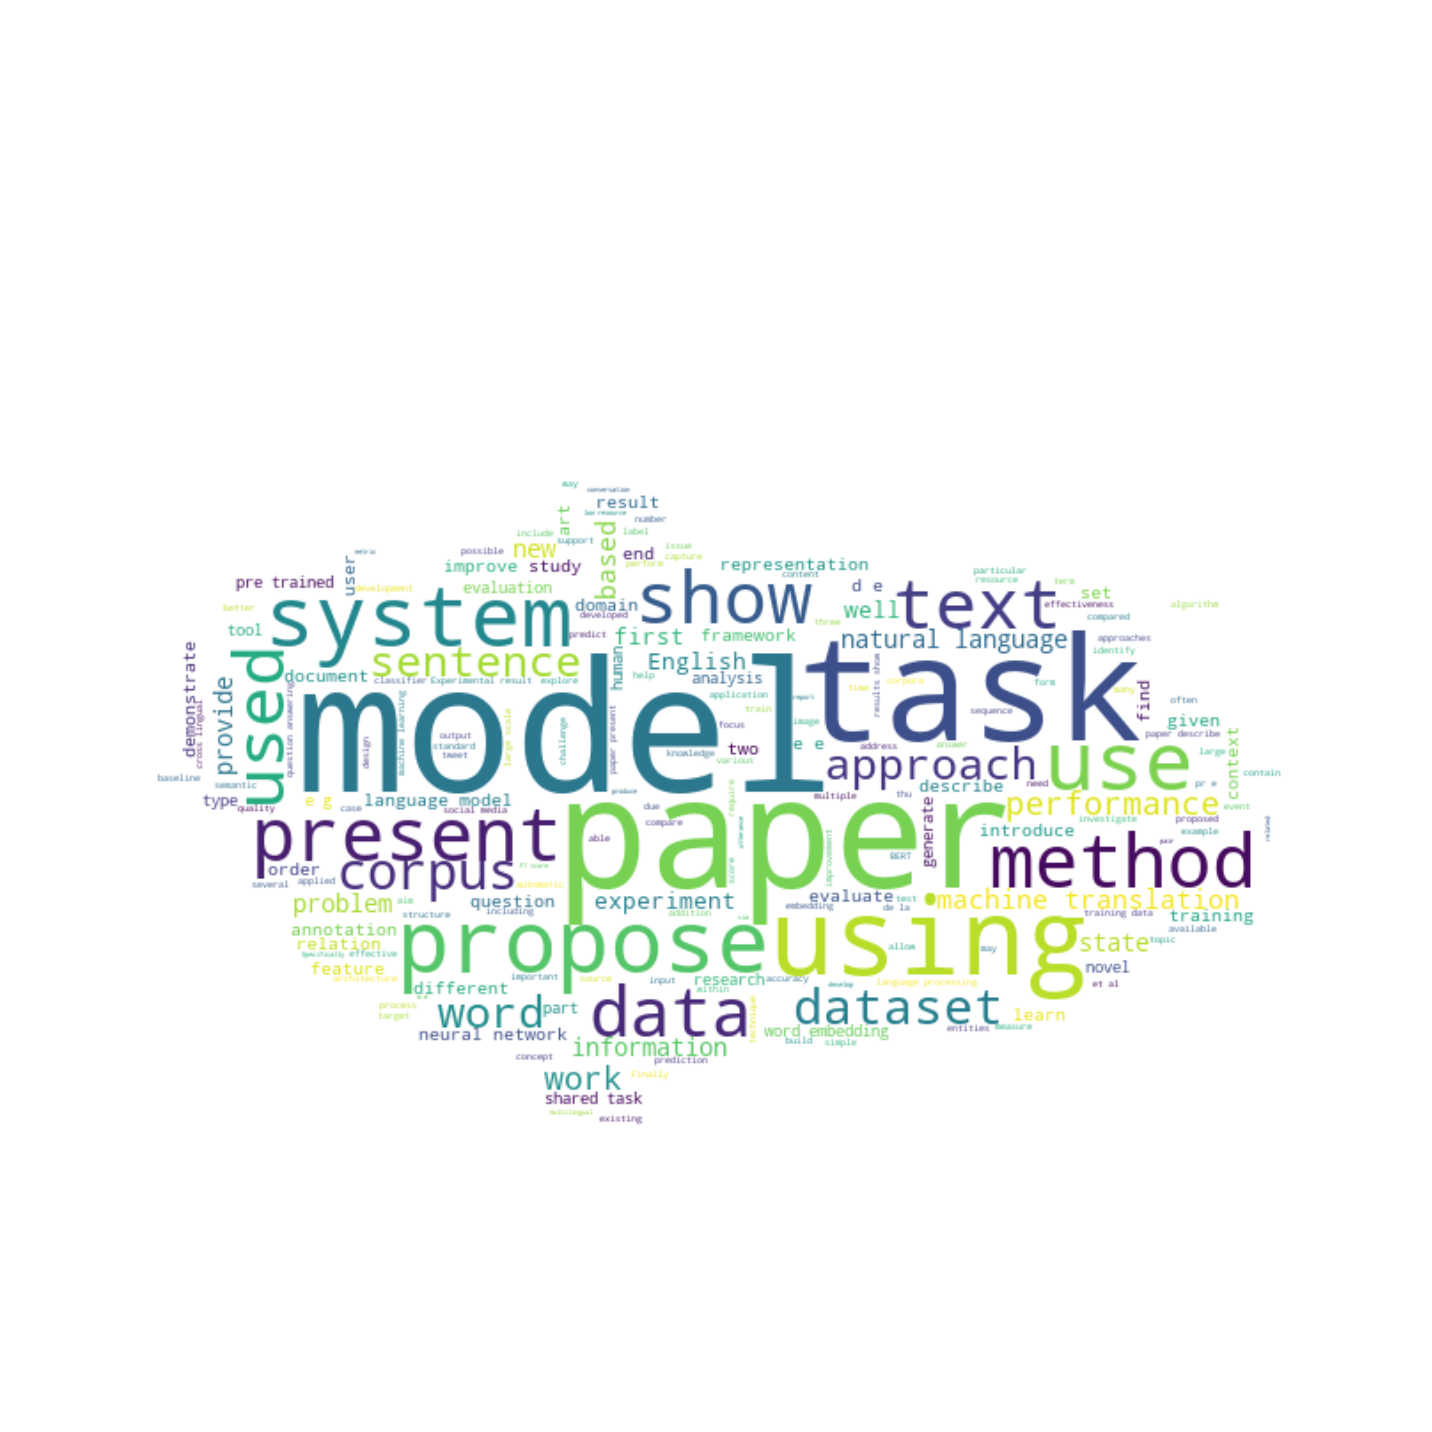

In [7]:
# Generate a word cloud image
from PIL import Image
from io import BytesIO
url = "https://thumbs.dreamstime.com/b/black-cloud-smoke-isolated-over-white-background-shape-illustration-102945454.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

mask = np.array(img)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=400, height=200, mask=mask).generate(text)

# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

## 3.	Modeling

### Prepare analytics here and construct all the data objects you will use in your report.
•	Write functions and classes to simplify tasks. Do not repeat yourself.

•	Avoid output.

•	Refactor your code until it’s clean

In [8]:
def get_shingles(text, k=5):
    """Get all shingles from requested file (hashes of these shingles)
    """
    L = len(text) # the length of each abstract
    shingles = set()  # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):
        shingle = text[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8')) #& 0xffffffff  # hash the shingle to a 32-bit integer
        shingles.add(crc)
    return shingles       

In [9]:
def jaccard_similarity_score(x, y):
    """
    Jaccard Similarity J (A,B) = | Intersection (A,B) | /
                                    | Union (A,B) |
    """
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [10]:
# fast implementation of Minhash algorithm
# computes all random hash functions for a shingle at once, using vector operations
# also finds element-wise minimum of two vectors efficiently
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [11]:
def LSH(signatures, bands, rows, Ab, Bb, nextPrime, maxShingleID):
    """Locality Sensitive Hashing
    """
    numItems = signatures.shape[1]
    signBands = np.array_split(signatures, bands, axis=0)
    candidates = set()
    for nb in range(bands):
        hashTable = {}
        for ni in range(numItems):
            item = signBands[nb][:,ni]
            hash = (np.dot(Ab[nb,:], item) + Bb[nb]) % nextPrime % maxShingleID
            if hash not in hashTable:
                hashTable[hash] = [ni]
            else:
                hashTable[hash].append(ni)
        for _,items in hashTable.items():
            if len(items) > 1:
                L = len(items)
                for i in range(L-1):
                    for j in range(i+1, L):
                        cand = [items[i], items[j]]
                        np.sort(cand)
                        candidates.add(tuple(cand))
    return candidates

In [18]:
# set global parameters to process the whole dataset
bands = 10
rows = 10
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

In [22]:
# here we need to store the results in matrices so we can print results in next section: not done atm
# parameters
s_th = [0.1,0.2]
k_shingles = [3,5,10]
random.seed(24)
random.shuffle(abstracts_clean) # randomly shuffle the list of abstracts and then pick the first 1000
abstracts_random = abstracts_clean[:999]
for s in s_th:
    for k in k_shingles:
        signatures = []  # signatures for all abstracts
        
        t = time()
        
        for abstract in abstracts_random: 
            shingles = get_shingles(abstract, k=k) # for minHash
            ShingleID = list(get_shingles(abstract, k=k))[0]
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig) # for minHash
            signatures.append(signature)
            
        #pair-wise jaccard-similarities    
        candidates = []

        for pair in itertools.combinations(abstracts_clean[:999],2):
            js = jaccard_similarity_score(get_shingles(pair[0], k=k),get_shingles(pair[1], k=k))

            if js > s:
                candidates.append(pair)
        t2 = time() - t
        print("Pairwise Jaccard-similarities with similarity threshold {} and k-shingles {}".format(s,k))
        print("finding candidates took {} seconds".format(t2))        
        print("Number of similar pairs: {}".format(len(candidates)))
        print("")

        # find candidates with MinHash
        Nfiles = len(signatures)
        t = time()
        candidates = []
        for i in range(Nfiles):
            for j in range(i+1, Nfiles):
                Jsim = np.mean(signatures[i] == signatures[j])  # average number of similar items in 
                if Jsim >= s:                                      # two vectors, equivalente to Jaccard 
                    candidates.append((i,j))
        t2 = time() - t
        print("MinHash with similarity threshold {} and k-shingles {}".format(s,k))
        print("finding candidates took {} seconds".format(t2))
        print("found {} candidates".format(len(candidates)))
        print("")
        
        # find candidates with LSH
        # prepare data for LSH
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors
        
        Nfiles = signatures.shape[1]  # number of different files
        t = time()
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t2 = time() - t
        print("LSH with similarity threshold {} and k-shingles {}".format(s,k))
        print("finding candidates took {} seconds".format(t2))
        print("found {} candidates".format(len(candidates)))
        print("")

Pairwise Jaccard-similarities with similarity threshold 0.1 and k-shingles 3
finding candidates took 524.6042857170105 seconds
Number of similar pairs: 490425

MinHash with similarity threshold 0.1 and k-shingles 3
finding candidates took 5.263071298599243 seconds
found 489005 candidates

LSH with similarity threshold 0.1 and k-shingles 3
finding candidates took 0.06251859664916992 seconds
found 1 candidates

Pairwise Jaccard-similarities with similarity threshold 0.1 and k-shingles 5
finding candidates took 498.65340423583984 seconds
Number of similar pairs: 3167

MinHash with similarity threshold 0.1 and k-shingles 5
finding candidates took 5.196054220199585 seconds
found 38093 candidates

LSH with similarity threshold 0.1 and k-shingles 5
finding candidates took 0.06251811981201172 seconds
found 0 candidates

Pairwise Jaccard-similarities with similarity threshold 0.1 and k-shingles 10
finding candidates took 509.7357759475708 seconds
Number of similar pairs: 0

MinHash with similar

## 4.	Results

-	Print out relevant tables nicely, display well-annotated charts and explain if needed in plain English.
-	Use minimum code here, just output-functions’ calls.

1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

2. Compare the results obtained for MinHash and LSH for different similarity thresholds *s* = 0.1, 0.2, 0.25 and 50, 100 and 200 hashing functions. Comment your results.

   3. For MinHashing using 100 hashing functions and *s* = 0.1 and 0.2,  find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each *s*. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

## 5.	Conclusions

•	Summarize your findings here in 5...10 lines of text.

In [23]:
#! git clone https://github.com/AlexTouvras/FindingSimilarItems

In [35]:
! git pull
! git add Mining_information.ipynb
! git commit -m "renamed notebooks"

! git push 

The file will have its original line endings in your working directory


U	anthology+abstracts.bib.gz


error: Committing is not possible because you have unmerged files.
hint: Fix them up in the work tree, and then use 'git add/rm <file>'
hint: as appropriate to mark resolution and make a commit.
fatal: Exiting because of an unresolved conflict.
To https://github.com/AlexTouvras/FindingSimilarItems
 ! [rejected]        main -> main (non-fast-forward)
error: failed to push some refs to 'https://github.com/AlexTouvras/FindingSimilarItems'
hint: Updates were rejected because the tip of your current branch is behind
hint: its remote counterpart. Integrate the remote changes (e.g.
hint: 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
